# Onderzoeksvraag 1

In hoeverre is de omzet (gross) van een film te voorspellen op basis van de populariteit op Facebook en IMDB?

### 1.1 Beschrijving van de dataset

De dataset bevat informatie over films, o.a.:

Populariteit: likes op Facebook van de film, regisseur en hoofdrolspelers.

IMDB-score: beoordeling van de film door gebruikers.

Budget & opbrengst: in dollars.

Overige kenmerken: genre, land, taal, jaar van uitgave, etc.

### 1.2 Relevante kolommen voor deze onderzoeksvraag

We focussen op deze features:

| Feature                     | Beschrijving                           | Type     |
| --------------------------- | -------------------------------------- | -------- |
| `director_facebook_likes`   | Aantal Facebook-likes van de regisseur | numeriek |
| `actor_1_facebook_likes`    | Likes hoofdrolspeler 1                 | numeriek |
| `actor_2_facebook_likes`    | Likes hoofdrolspeler 2                 | numeriek |
| `actor_3_facebook_likes`    | Likes hoofdrolspeler 3                 | numeriek |
| `cast_total_facebook_likes` | Totale likes van de cast               | numeriek |
| `movie_facebook_likes`      | Likes van de film zelf                 | numeriek |
| `imdb_score`                | IMDB-score                             | numeriek |
| `num_voted_users`           | Aantal IMDB-stemmers                   | numeriek |
| `budget`                    | Budget van de film (controlevariabele) | numeriek |
| `gross`                     | **Targetvariabele** – omzet  | numeriek |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
bestand = "movie-1-cleaned.csv"
df = pd.read_csv(bestand, encoding='utf-8')

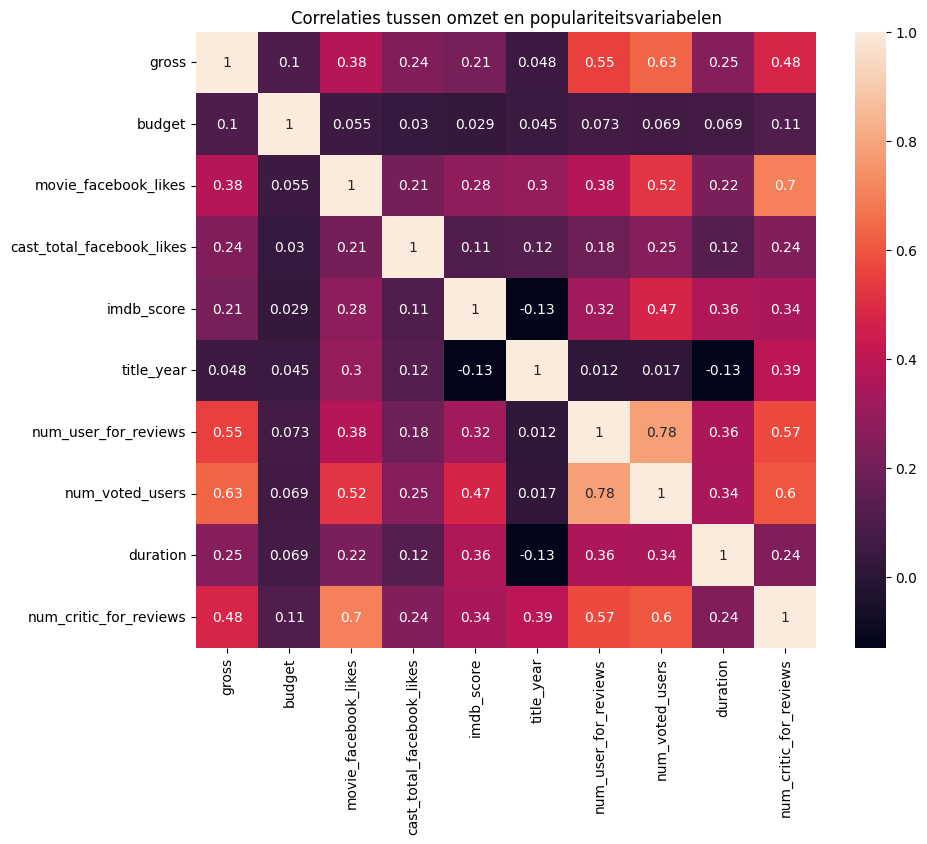

In [3]:
# Beschrijving
df.describe()

# Missende waarden
df.isnull().sum()

# Correlaties
plt.figure(figsize=(10,8))
sns.heatmap(df[['gross', 'budget', 'movie_facebook_likes', 'cast_total_facebook_likes', 'imdb_score', 'title_year', 'num_user_for_reviews', 'num_voted_users', 'duration', 'num_critic_for_reviews' ]].corr(), annot=True)
plt.title("Correlaties tussen omzet en populariteitsvariabelen")
plt.show()


In [4]:
df['log_budget'] = np.log1p(df['budget'])
df['log_gross'] = np.log1p(df['gross'])

df['log_num_user_for_reviews'] = np.log1p(df['num_user_for_reviews'])
df['log_num_voted_users'] = np.log1p(df['num_voted_users'])
df['log_movie_facebook_likes'] = np.log1p(df['movie_facebook_likes'])

df['interaction_budget_imdb'] = df['log_budget'] * df['imdb_score']
df['review_ratio'] = df['log_num_user_for_reviews'] / (df['log_num_voted_users'] + 1e-6)
df['movie_age'] = 2025 - df['title_year']

In [5]:
#X = df[['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
#        'actor_3_facebook_likes', 'cast_total_facebook_likes', 'movie_facebook_likes',
#        'imdb_score', 'num_voted_users', 'log_budget']]

#X = df[['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
#        'actor_3_facebook_likes', 'cast_total_facebook_likes', 'log_movie_facebook_likes',
#        'imdb_score', 'log_num_voted_users', 'log_budget', 'log_num_user_for_reviews', 'num_critic_for_reviews']]

X = df[['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
        'actor_3_facebook_likes', 'cast_total_facebook_likes', 'log_movie_facebook_likes',
        'imdb_score', 'log_num_voted_users', 'log_budget', 'log_num_user_for_reviews',
        'num_critic_for_reviews', 'interaction_budget_imdb', 'review_ratio', 'movie_age']]

y = df['log_gross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=40,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2_rf:.3f}, RMSE: {rmse_rf:.3f}")


R²: 0.628, RMSE: 1.345


In [7]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Extra Trees Regressor aanmaken
et = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=40,
    random_state=42
)

# Trainen
et.fit(X_train, y_train)

# Voorspellingen
y_pred_et = et.predict(X_test)

# Prestaties meten
r2_et = r2_score(y_test, y_pred_et)
rmse_et = np.sqrt(mean_squared_error(y_test, y_pred_et))

print(f"Extra Trees Regressor -> R²: {r2_et:.3f}, RMSE: {rmse_et:.3f}")


Extra Trees Regressor -> R²: 0.636, RMSE: 1.331


R²: 0.600, RMSE: 1.394

## Modelen geprobeerd 
### Lineair modelen
Linear Regression

Ridge Regression

Lasso Regression 

ElasticNet

### Boomgebaseerde modellen
Decision Tree

Random Forest

Extra Trees

Gradient Boosting

### Niet-lineair model
KNN Regressor


In [ ]:


param_grid = {
    'n_estimators': [300, 400, 500, 700, 800, 900, 1000, 1500, 2000],
    'max_depth': [20, 30, 40, 50, 60, 70, None],
    'min_samples_split': [1, 2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

# =======================
# Random Forest tuning
# =======================
rf = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Beste Random Forest params:", rf_search.best_params_)

et = ExtraTreesRegressor(random_state=42)
et_search = RandomizedSearchCV(
    estimator=et,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
et_search.fit(X_train, y_train)
best_et = et_search.best_estimator_
print("Beste Extra Trees params:", et_search.best_params_)

ensemble = VotingRegressor(estimators=[('rf', best_rf), ('et', best_et)])
ensemble.fit(X_train, y_train)

models = {
    "Random Forest": best_rf,
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} -> R²: {r2:.3f}, RMSE: {rmse:.3f}")

    # Scatterplot
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Werkelijke log(omzet)")
    plt.ylabel("Voorspelde log(omzet)")
    plt.title(f"{name}: Voorspelling vs Werkelijke omzet")
    plt.show()

# =======================
# Feature importances
# =======================
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)
print("\nFeature importances Random Forest:")
print(importances)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature importances Random Forest")
plt.show()

# =======================
# Overfitting controle
# =======================

# Prestaties op train en test set
train_scores = {}
test_scores = {}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_scores[name] = (r2_train, rmse_train)
    test_scores[name] = (r2_test, rmse_test)
    
    print(f"\n{name} overfitting check:")
    print(f"Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}")
    print(f"Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")

# =======================
# Visualisatie R² train vs test
# =======================
r2_train_vals = [v[0] for v in train_scores.values()]
r2_test_vals = [v[0] for v in test_scores.values()]
model_names = list(models.keys())

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, r2_train_vals, width, label='Train R²')
plt.bar(x + width/2, r2_test_vals, width, label='Test R²')
plt.xticks(x, model_names)
plt.ylabel("R² score")
plt.title("Train vs Test R² — Overfitting Check")
plt.legend()
plt.show()

# =======================
# Visualisatie RMSE train vs test
# =======================
rmse_train_vals = [v[1] for v in train_scores.values()]
rmse_test_vals = [v[1] for v in test_scores.values()]

plt.figure(figsize=(8,6))
plt.bar(x - width/2, rmse_train_vals, width, label='Train RMSE')
plt.bar(x + width/2, rmse_test_vals, width, label='Test RMSE')
plt.xticks(x, model_names)
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE — Overfitting Check")
plt.legend()
plt.show()


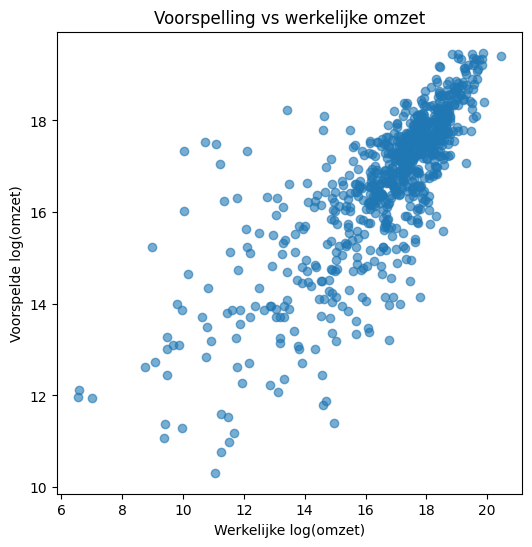

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Werkelijke log(omzet)")
plt.ylabel("Voorspelde log(omzet)")
plt.title("Voorspelling vs werkelijke omzet")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# =======================
# Data inladen
# =======================
bestand = "movie-1-cleaned.csv"
df = pd.read_csv(bestand, encoding='utf-8')

# Basisbeschrijving
print(df.describe())
print("\nMissende waarden per kolom:\n", df.isnull().sum())

# =======================
# Correlatie heatmap
# =======================
plt.figure(figsize=(10,8))
corr_features = ['gross', 'budget', 'movie_facebook_likes', 'cast_total_facebook_likes',
                 'imdb_score', 'title_year', 'num_user_for_reviews', 'num_voted_users',
                 'duration', 'num_critic_for_reviews']
sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlaties tussen omzet en populariteitsvariabelen")
plt.show()

# =======================
# Log-transformaties
# =======================
df['log_budget'] = np.log1p(df['budget'])
df['log_gross'] = np.log1p(df['gross'])
df['log_num_user_for_reviews'] = np.log1p(df['num_user_for_reviews'])
df['log_num_voted_users'] = np.log1p(df['num_voted_users'])
df['log_movie_facebook_likes'] = np.log1p(df['movie_facebook_likes'])

# =======================
# Feature engineering
# =======================
df['interaction_budget_imdb'] = df['log_budget'] * df['imdb_score']
df['review_ratio'] = df['log_num_user_for_reviews'] / (df['log_num_voted_users'] + 1e-6)
df['movie_age'] = 2025 - df['title_year']

# =======================
# Features en target
# =======================
X = df[['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
        'actor_3_facebook_likes', 'cast_total_facebook_likes', 'log_movie_facebook_likes',
        'imdb_score', 'log_num_voted_users', 'log_budget', 'log_num_user_for_reviews',
        'num_critic_for_reviews', 'interaction_budget_imdb', 'review_ratio', 'movie_age']]

y = df['log_gross']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =======================
# Random Forest en Extra Trees (beperkte complexiteit)
# =======================
best_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=40,
    random_state=42
)
best_rf.fit(X_train, y_train)

best_et = ExtraTreesRegressor(
    n_estimators=500,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)
best_et.fit(X_train, y_train)

# =======================
# Ensemble model
# =======================
ensemble = VotingRegressor(estimators=[('rf', best_rf), ('et', best_et)])
ensemble.fit(X_train, y_train)

# =======================
# Evaluatie modellen
# =======================
models = {
    "Random Forest": best_rf,
    "Extra Trees": best_et,
    "Ensemble": ensemble
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} -> R²: {r2:.3f}, RMSE: {rmse:.3f}")

    # Scatterplot
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Werkelijke log(omzet)")
    plt.ylabel("Voorspelde log(omzet)")
    plt.title(f"{name}: Voorspelling vs Werkelijke omzet")
    plt.show()

# =======================
# Feature importances Random Forest
# =======================
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)
print("\nFeature importances Random Forest:")
print(importances)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature importances Random Forest")
plt.show()

# =======================
# Overfitting controle
# =======================
train_scores = {}
test_scores = {}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_scores[name] = (r2_train, rmse_train)
    test_scores[name] = (r2_test, rmse_test)
    
    print(f"\n{name} overfitting check:")
    print(f"Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}")
    print(f"Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")

# =======================
# Visualisatie R² train vs test
# =======================
r2_train_vals = [v[0] for v in train_scores.values()]
r2_test_vals = [v[0] for v in test_scores.values()]
model_names = list(models.keys())

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, r2_train_vals, width, label='Train R²')
plt.bar(x + width/2, r2_test_vals, width, label='Test R²')
plt.xticks(x, model_names)
plt.ylabel("R² score")
plt.title("Train vs Test R² — Overfitting Check")
plt.legend()
plt.show()

# =======================
# Visualisatie RMSE train vs test
# =======================
rmse_train_vals = [v[1] for v in train_scores.values()]
rmse_test_vals = [v[1] for v in test_scores.values()]

plt.figure(figsize=(8,6))
plt.bar(x - width/2, rmse_train_vals, width, label='Train RMSE')
plt.bar(x + width/2, rmse_test_vals, width, label='Test RMSE')
plt.xticks(x, model_names)
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE — Overfitting Check")
plt.legend()
plt.show()


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Beste parameters: {'model__subsample': 0.8, 'model__reg_lambda': 1.0, 'model__reg_alpha': 0.5, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Beste XGBoost -> R²: 0.657, RMSE: 1.291


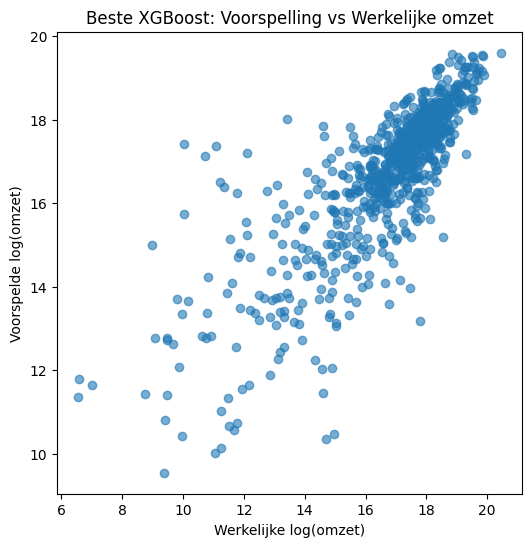

Stacking Ensemble -> R²: 0.637, RMSE: 1.328


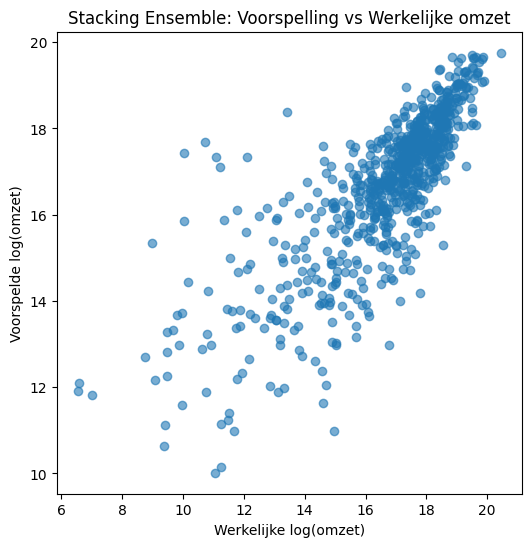

Gemiddelde cross-val R²: 0.376 ± 0.029


KeyboardInterrupt: 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# Data inladen
# ==========================================
bestand = "movie-1-cleaned.csv"
df = pd.read_csv(bestand, encoding='utf-8')

# Log-transformaties en feature engineering
df['log_budget'] = np.log1p(df['budget'])
df['log_gross'] = np.log1p(df['gross'])
df['log_num_user_for_reviews'] = np.log1p(df['num_user_for_reviews'])
df['log_num_voted_users'] = np.log1p(df['num_voted_users'])
df['log_movie_facebook_likes'] = np.log1p(df['movie_facebook_likes'])
df['interaction_budget_imdb'] = df['log_budget'] * df['imdb_score']
df['review_ratio'] = df['log_num_user_for_reviews'] / (df['log_num_voted_users'] + 1e-6)
df['movie_age'] = 2025 - df['title_year']

X = df[['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
        'actor_3_facebook_likes', 'cast_total_facebook_likes', 'log_movie_facebook_likes',
        'imdb_score', 'log_num_voted_users', 'log_budget', 'log_num_user_for_reviews',
        'num_critic_for_reviews', 'interaction_budget_imdb', 'review_ratio', 'movie_age']]
y = df['log_gross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# Modelpipeline met scaling en tuning
# ==========================================
# Basis pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparameter tuning (klein grid voor snelheid)
param_distributions = {
    'model__n_estimators': [200, 300, 400],  # minder bomen
    'model__max_depth': [3, 4, 5],           # minder diepe bomen = minder overfitting
    'model__learning_rate': [0.05, 0.1],     # iets hogere learning rate voorkomt extreme fine-tuning
    'model__min_child_weight': [1, 2, 3],    # zorgt dat een node meer data nodig heeft om te splitsen
    'model__subsample': [0.6, 0.8],          # elke boom ziet minder data
    'model__colsample_bytree': [0.6, 0.8],   # elke boom ziet minder features
    'model__reg_lambda': [1.0, 2.0, 3.0],    # sterkere L2-regularisatie
    'model__reg_alpha': [0.1, 0.3, 0.5],     # L1-regularisatie voor eenvoudiger model
}


search = RandomizedSearchCV(pipe, param_distributions, n_iter=30, scoring='r2', cv=5, verbose=1, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

print("Beste parameters:", search.best_params_)
best_model = search.best_estimator_

# ==========================================
# Stacking Ensemble (voor meer generalisatie)
# ==========================================
base_models = [
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)),
    ('et', ExtraTreesRegressor(n_estimators=300, max_depth=20, random_state=42))
#    ('xgb', best_model.named_steps['model']),
#    ('enet', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))

        ]
#stack = StackingRegressor(
#    estimators=base_models,
#    final_estimator=ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=42),
#    n_jobs=-1
)
stack.fit(X_train, y_train)

# ==========================================
# Evaluatie
# ==========================================
def evaluate(model, name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} -> R²: {r2:.3f}, RMSE: {rmse:.3f}")
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel("Werkelijke log(omzet)")
    plt.ylabel("Voorspelde log(omzet)")
    plt.title(f"{name}: Voorspelling vs Werkelijke omzet")
    plt.show()

evaluate(best_model, "Beste XGBoost")
evaluate(stack, "Stacking Ensemble")

# ==========================================
# Cross-validation score (betrouwbaarder)
# ==========================================
cv_scores = cross_val_score(stack, X, y, cv=5, scoring='r2')
print(f"Gemiddelde cross-val R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ==========================================
# Learning curve check (overfitting zichtbaar)
# ==========================================
train_sizes, train_scores, test_scores = learning_curve(stack, X, y, cv=5, scoring='r2', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Test score')
plt.xlabel("Trainingsetgrootte")
plt.ylabel("R² score")
plt.title("Learning Curve — Overfitting Analyse")
plt.legend()
plt.show()


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Beste parameters: {'model__subsample': 0.8, 'model__reg_lambda': 1.0, 'model__reg_alpha': 0.5, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
===== Modelvergelijking =====
           Model        R2      RMSE
0  Beste XGBoost  0.657445  1.290601

➡️ Beste model: Beste XGBoost (R²=0.657, RMSE=1.291)


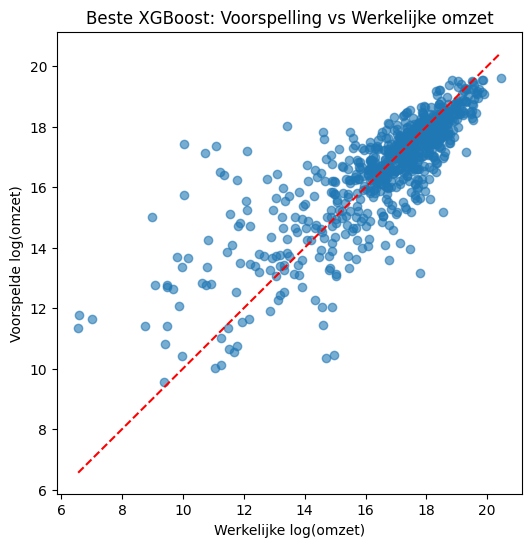

Beste XGBoost - Cross-val R²: 0.376 ± 0.043


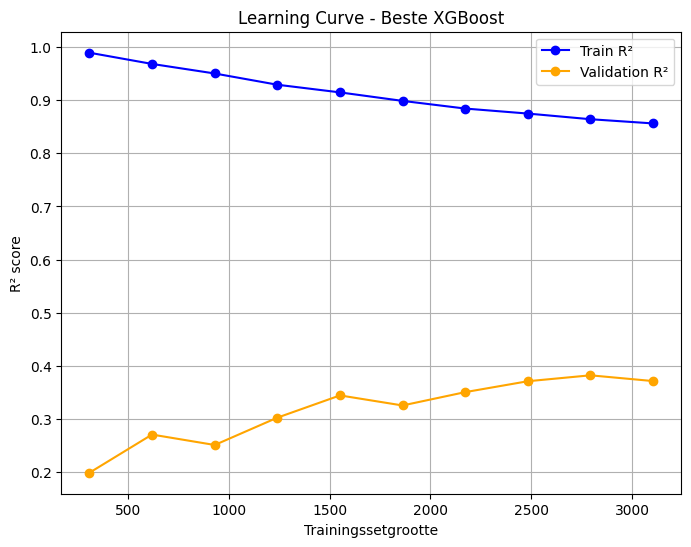

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# Data inladen
# ==========================================
bestand = "movie-1-cleaned.csv"
df = pd.read_csv(bestand, encoding='utf-8')

# Log-transformaties en feature engineering
df['log_budget'] = np.log1p(df['budget'])
df['log_gross'] = np.log1p(df['gross'])
df['log_num_user_for_reviews'] = np.log1p(df['num_user_for_reviews'])
df['log_num_voted_users'] = np.log1p(df['num_voted_users'])
df['log_movie_facebook_likes'] = np.log1p(df['movie_facebook_likes'])
df['interaction_budget_imdb'] = df['log_budget'] * df['imdb_score']
df['review_ratio'] = df['log_num_user_for_reviews'] / (df['log_num_voted_users'] + 1e-6)
df['movie_age'] = 2025 - df['title_year']

X = df[['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
        'actor_3_facebook_likes', 'cast_total_facebook_likes', 'log_movie_facebook_likes',
        'imdb_score', 'log_num_voted_users', 'log_budget', 'log_num_user_for_reviews',
        'num_critic_for_reviews', 'interaction_budget_imdb', 'review_ratio', 'movie_age']]
y = df['log_gross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# Modelpipeline met scaling en tuning
# ==========================================
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_distributions = {
    'model__n_estimators': [200, 300, 400],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.05, 0.1],
    'model__min_child_weight': [1, 2, 3],
    'model__subsample': [0.6, 0.8],
    'model__colsample_bytree': [0.6, 0.8],
    'model__reg_lambda': [1.0, 2.0, 3.0],
    'model__reg_alpha': [0.1, 0.3, 0.5],
}

search = RandomizedSearchCV(pipe, param_distributions, n_iter=30, scoring='r2', cv=5,
                            verbose=1, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

print("Beste parameters:", search.best_params_)
best_model = search.best_estimator_



# ==========================================
# Functie om modellen te evalueren
# ==========================================
def evaluate_models(models_dict):
    results = []
    for name, model in models_dict.items():
        if model is None:
            continue
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results.append({'Model': name, 'R2': r2, 'RMSE': rmse})
    
    results_df = pd.DataFrame(results)
    best_idx = results_df['R2'].idxmax()
    best_model_name = results_df.loc[best_idx, 'Model']
    
    print("===== Modelvergelijking =====")
    print(results_df)
    print(f"\n➡️ Beste model: {best_model_name} (R²={results_df.loc[best_idx, 'R2']:.3f}, RMSE={results_df.loc[best_idx, 'RMSE']:.3f})")
    
    # Scatterplots
    for name, model in models_dict.items():
        if model is None:
            continue
        y_pred = model.predict(X_test)
        plt.figure(figsize=(6,6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Werkelijke log(omzet)")
        plt.ylabel("Voorspelde log(omzet)")
        plt.title(f"{name}: Voorspelling vs Werkelijke omzet")
        plt.show()

# Evaluatie uitvoeren
models_to_test = {
    "Beste XGBoost": best_model,
    "Stacking Ensemble": stack
}
evaluate_models(models_to_test)

# ==========================================
# Cross-validation score
# ==========================================
for name, model in models_to_test.items():
    if model is None:
        continue
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name} - Cross-val R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ==========================================
# Learning curve voor overfitting check
# ==========================================
for name, model in models_to_test.items():
    if model is None:
        continue
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='r2', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
    plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation R²')
    plt.xlabel("Trainingssetgrootte")
    plt.ylabel("R² score")
    plt.title(f"Learning Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


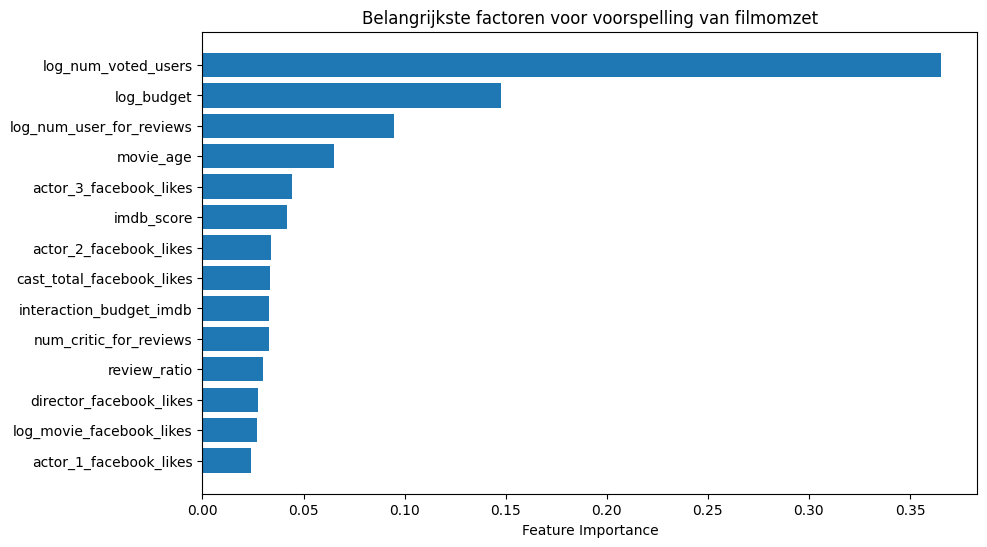

In [33]:
# Het XGBoost-model uit je pipeline halen
xgb_model = best_model.named_steps['model']

# Feature importances ophalen
importances = xgb_model.feature_importances_
feature_names = X.columns

# DataFrame voor overzicht
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Visualisatie
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()  # Belangrijkste bovenaan
plt.xlabel("Feature Importance")
plt.title("Belangrijkste factoren voor voorspelling van filmomzet")
plt.show()


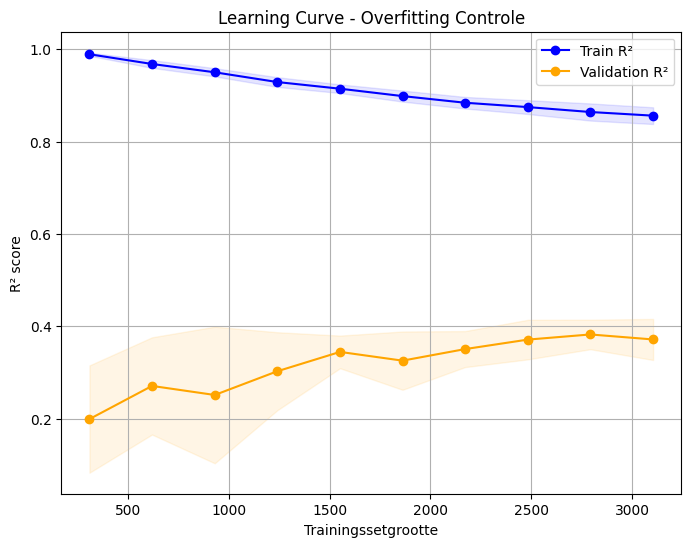

In [34]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Gebruik het beste XGBoost-model
model = best_model

# Bereken learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

# Gemiddelde en standaarddeviatie
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plotten
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation R²')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.xlabel("Trainingssetgrootte")
plt.ylabel("R² score")
plt.title("Learning Curve - Overfitting Controle")
plt.legend()
plt.grid(True)
plt.show()
